In [1]:
import pandas as pd
import numpy as np

prefix = './logs/single-worker_500tps_'
df = pd.concat([pd.read_csv(prefix+'logs-server.csv', sep=';'), pd.read_csv(prefix+'logs-worker.csv', sep=';')])

In [2]:
df.head(5)

,timestamp,partition,vectorClock,loss,fMeasure,accuracy
0,1584266951862,-1,0,-1.0,0.137006,0.245028
1,1584266954428,-1,1,-1.0,0.173582,0.268198
2,1584266956554,-1,2,-1.0,0.230541,0.274349
3,1584266958454,-1,3,-1.0,0.216616,0.277015
4,1584266960574,-1,4,-1.0,0.268593,0.284396


In [3]:
numPartitions = 1

In [4]:
df.loc[df['partition'] == -1, 'partition'] = numPartitions
numPartitions = numPartitions + 1

In [5]:
maxVC = [0 for i in range(numPartitions)]
for p in range(numPartitions):
    maxWithinPartition = max(df[df['partition'] == p]['vectorClock'])
    maxVC[p] = max(maxVC[p], maxWithinPartition)
maxVC = min(maxVC)
#maxVC = 750
maxVC

765

In [6]:
df = df[df['vectorClock'] <= maxVC].reset_index().sort_values('vectorClock')

In [7]:
data = {
    **{'loss'+str(i): [] for i in range(numPartitions)},
    **{'fMesaure'+str(i): [] for i in range(numPartitions)},
    **{'accuracy'+str(i): [] for i in range(numPartitions)}
}

for p in range(numPartitions):
    for index, row in df[df['partition'] == p].iterrows():
        data['loss'+str(p)] += [row['loss']]
        data['fMesaure'+str(p)] += [row['fMeasure']]
        data['accuracy'+str(p)] += [row['accuracy']]

In [8]:
data = pd.DataFrame(data)

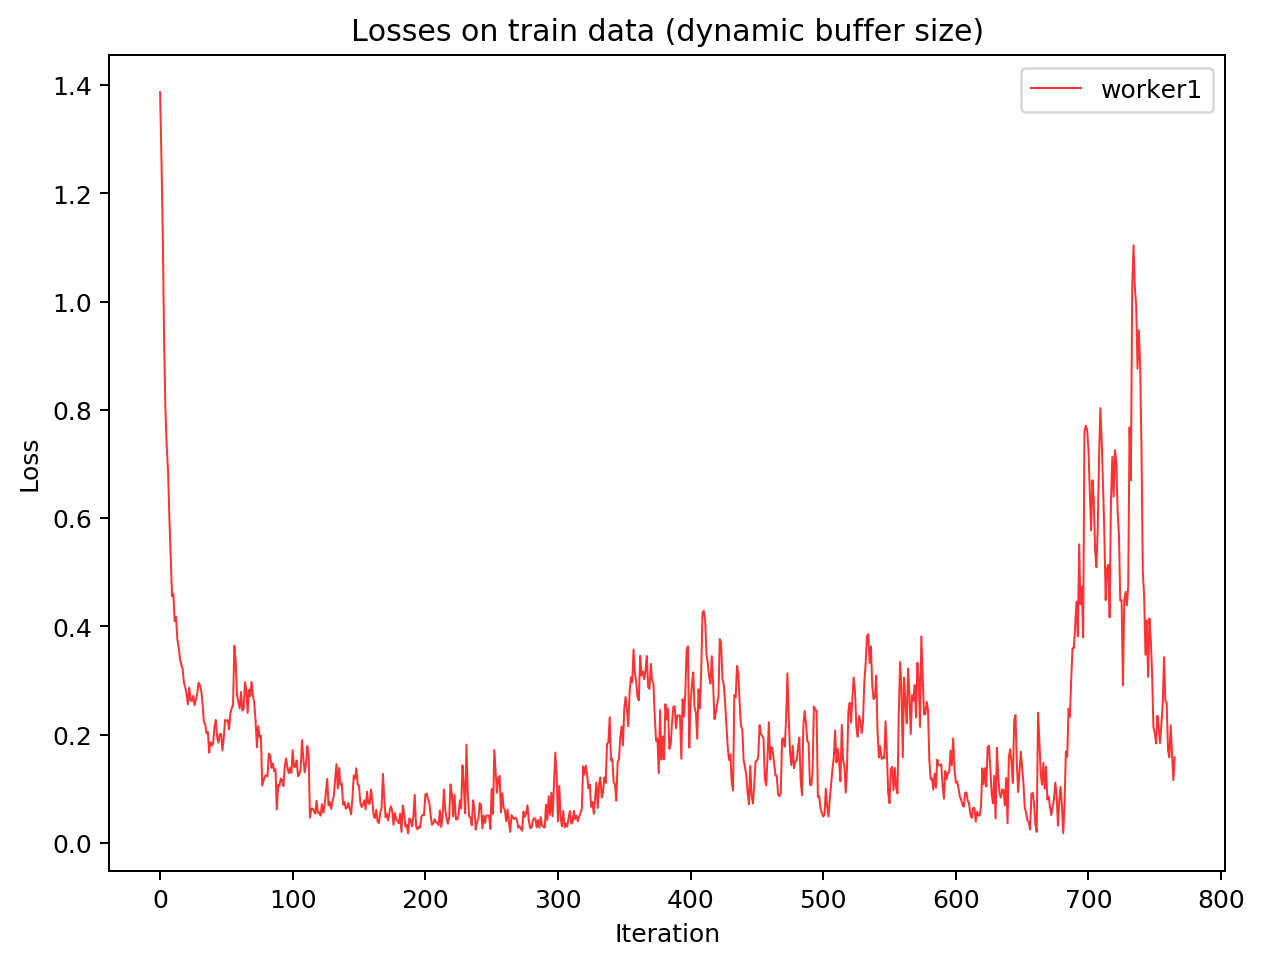

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, ylim

figure(num=None, figsize=(8, 6), dpi=180, facecolor='w', edgecolor='k')
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'

data['x'] = [i for i in range(len(data))]

# create a color palette
palette = ['red', 'blue', 'green', 'orange', 'purple']

for i in range(numPartitions - 1):
    col = 'loss' + str(i)
    
    isServerPartition = i == numPartitions - 1
    alpha = 0.8
    label = 'server' if isServerPartition else 'worker'+str(i+1)
    linewidth = 0.8
    plt.plot(data['x'], data[col], marker='', color=palette[i], linewidth=linewidth, alpha=alpha, label=label)

#ylim(0, 1e-4)
plt.title('Losses on train data (dynamic buffer size)')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.legend(loc=1, ncol=2)
plt.show()

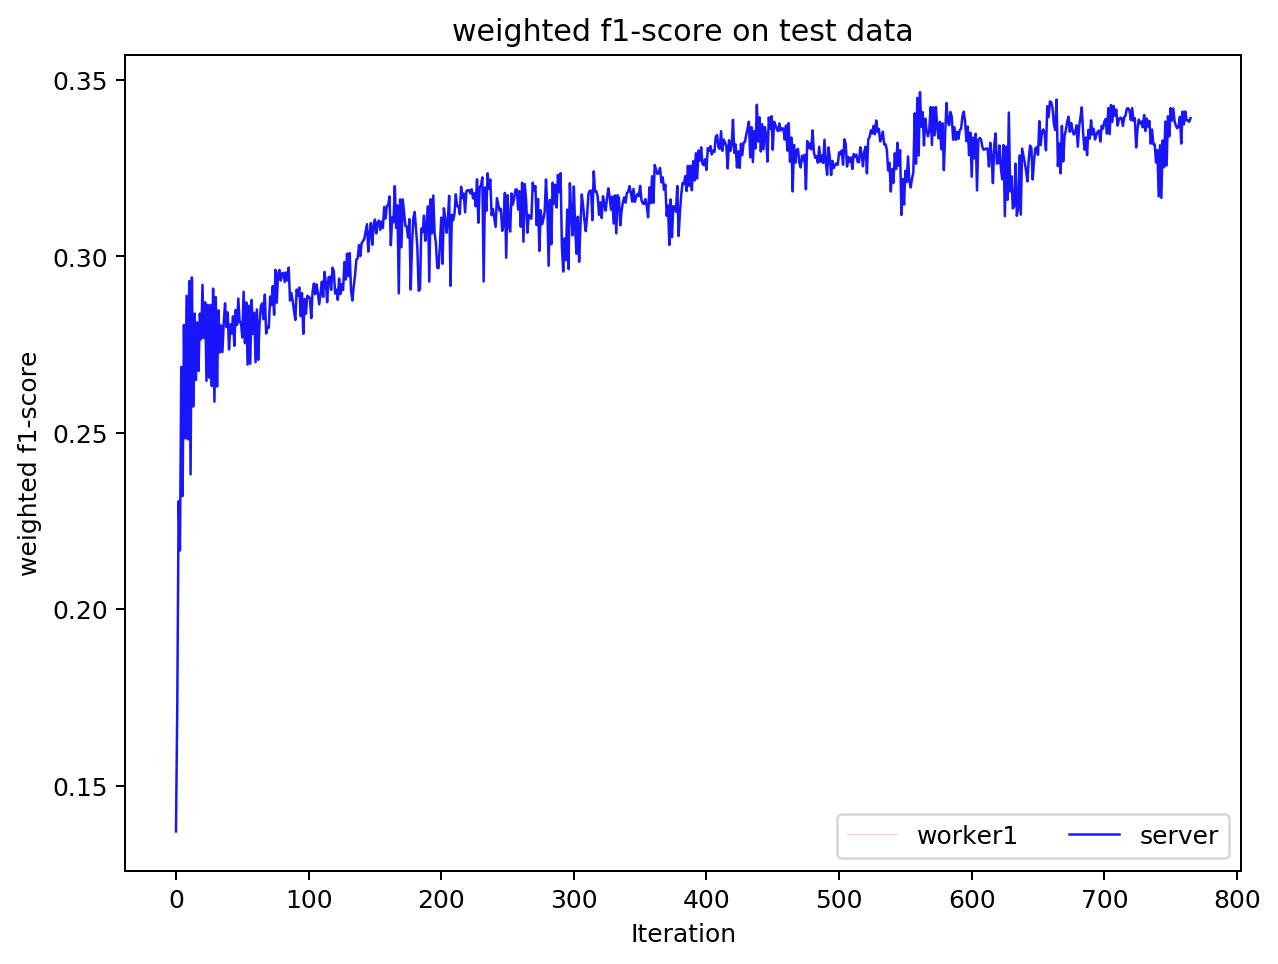

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, ylim

figure(num=None, figsize=(8, 6), dpi=180, facecolor='w', edgecolor='k')
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'

data['x'] = [i for i in range(len(data))]

# create a color palette
palette = ['red', 'blue', 'green', 'orange', 'purple']

for i in range(numPartitions):
    col = 'fMesaure' + str(i)
    
    isServerPartition = i == numPartitions - 1
    alpha = 0.9 if isServerPartition else 0.2
    label = 'server' if isServerPartition else 'worker'+str(i+1)
    linewidth = 1 if isServerPartition else 0.5
    plt.plot(data['x'], data[col], marker='', color=palette[i], linewidth=linewidth, alpha=alpha, label=label)

#ylim(0, 1e-4)
plt.title('weighted f1-score on test data')
plt.ylabel('weighted f1-score')
plt.xlabel('Iteration')
plt.legend(loc=4, ncol=2)
plt.show()

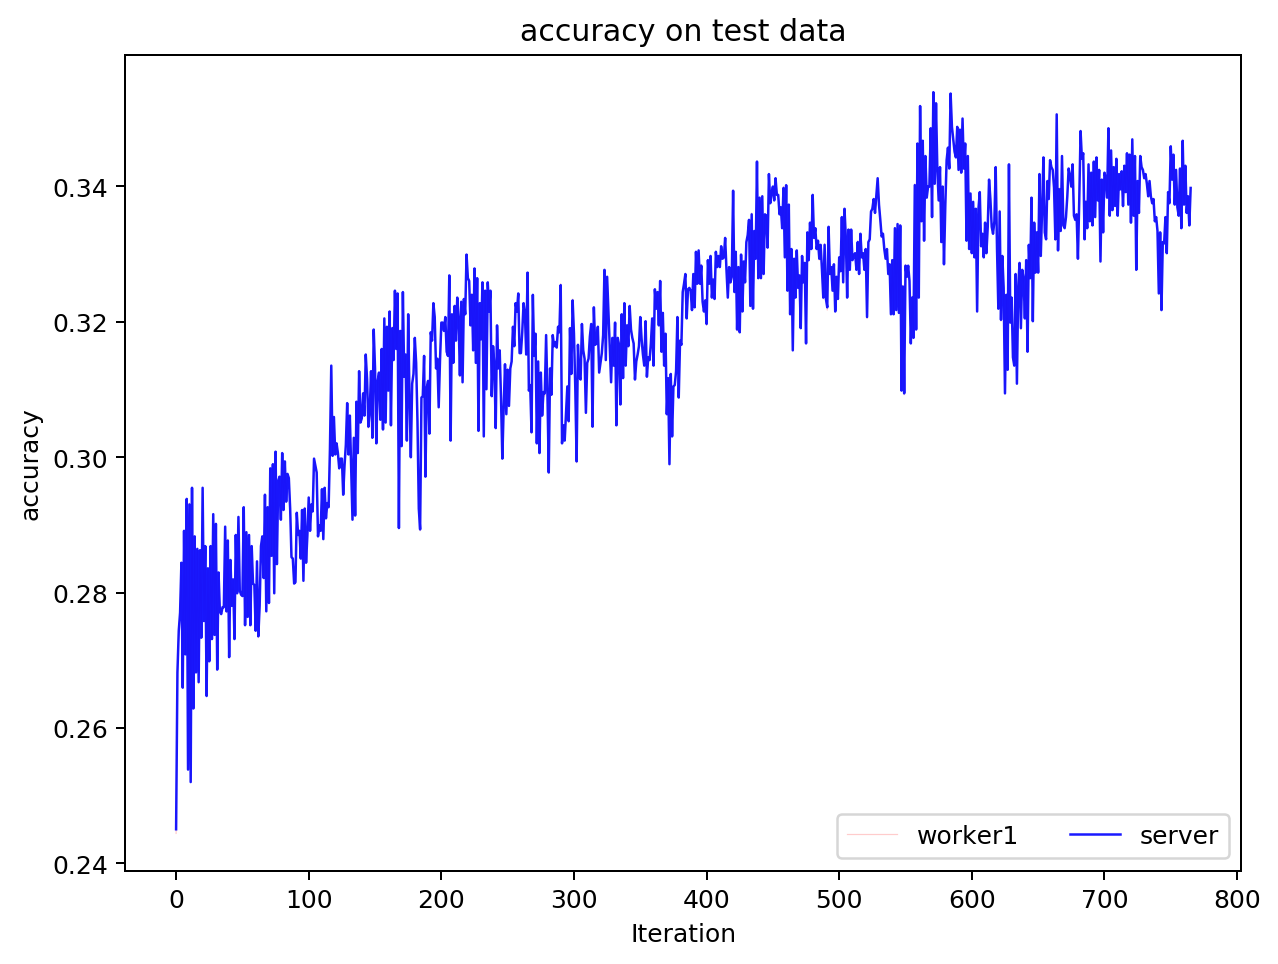

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, ylim

figure(num=None, figsize=(8, 6), dpi=180, facecolor='w', edgecolor='k')
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'

data['x'] = [i for i in range(len(data))]

# create a color palette
palette = ['red', 'blue', 'green', 'orange', 'purple']

for i in range(numPartitions):
    col = 'accuracy' + str(i)
    
    isServerPartition = i == numPartitions - 1
    alpha = 0.9 if isServerPartition else 0.2
    label = 'server' if isServerPartition else 'worker'+str(i+1)
    linewidth = 1 if isServerPartition else 0.5
    plt.plot(data['x'], data[col], marker='', color=palette[i], linewidth=linewidth, alpha=alpha, label=label)

#ylim(0, 1e-4)
plt.title('accuracy on test data')
plt.ylabel('accuracy')
plt.xlabel('Iteration')
plt.legend(loc=4, ncol=2)
plt.show()